# Retail Sales Dataset: Comprehensive Explortory Data Analysis

**Goal**


*   Validate data integrity and schema assuptions
*   Undersatnd demand, pricing and promotion behavior
*   Quantify temporal patterns (Trends + Seasonality)




**Setup**

In [ ]:
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

warnings.filterwarnings("ignore")

# Plot style tuned for readable, report-quality visuals.
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams.update({
    "figure.figsize": (13, 6),
    "axes.titlesize": 18,
    "axes.titleweight": "bold",
    "axes.labelsize": 13,
    "axes.labelweight": "semibold",
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 11,
    "figure.dpi": 120,
})

palette_main = ["#0F4C82", "#E67E21", "#2A9D7F", "#E63945", "#6A4C94", "#8D99AF"]

flile_path = "/content/drive/MyDrive/datasets /retail_sales.csv"
df1 = pd.read_csv(flile_path)
print(df1.head())

         date store_id item_id  sales  price  promo  weekday  month
0  2019-01-01  store_1  item_1     41  21.30      0        1      1
1  2019-01-02  store_1  item_1     53  21.30      0        2      1
2  2019-01-03  store_1  item_1     39  21.30      0        3      1
3  2019-01-04  store_1  item_1     35  21.30      0        4      1
4  2019-01-05  store_1  item_1     51  17.04      1        5      1


In [ ]:
dtype_map = {
    "store_id": "category",
    "item_id": "category",
    "sales": "int32",
    "price": "float32",
    "promo": "float32", # Changed from 'int8' to 'float32' to handle potential NA values
    "weekday": "float32", # Changed from 'int8' to 'float32' to handle potential NA values
    "month": "int8",
}

df = pd.read_csv(flile_path,parse_dates=['date'],dtype=dtype_map)

Derived fields used throughout EDA.

In [ ]:
df["year"] = df["date"].dt.year.astype("int16")
df["day_name"] = pd.Categorical(
    df["date"].dt.day_name(),
    categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
    ordered=True,
)
df["is_weekend"] = df["weekday"].isin([5, 6]).astype("int8")

mem_mb = df.memory_usage(deep=True).sum() / (1024 ** 2)
print(f"Loaded {len(df):,} rows x {df.shape[1]} columns")
print(f"Approx. memory usage: {mem_mb:,.1f} MB")

Loaded 4,565,000 rows x 11 columns
Approx. memory usage: 135.0 MB


In [ ]:
df.head()

,date,store_id,item_id,sales,price,promo,weekday,month,year,day_name,is_weekend
0,2019-01-01,store_1,item_1,41,21.299999,0.0,1.0,1,2019,Tuesday,0
1,2019-01-02,store_1,item_1,53,21.299999,0.0,2.0,1,2019,Wednesday,0
2,2019-01-03,store_1,item_1,39,21.299999,0.0,3.0,1,2019,Thursday,0
3,2019-01-04,store_1,item_1,35,21.299999,0.0,4.0,1,2019,Friday,0
4,2019-01-05,store_1,item_1,51,17.040001,1.0,5.0,1,2019,Saturday,1


Dataset Overview

In [ ]:
start_date = df["date"].min()
end_date = df["date"].max()
num_days = df["date"].nunique()
num_stores = df["store_id"].nunique()
num_items = df["item_id"].nunique()

overview = pd.DataFrame({
    "Metric": [
        "Rows",
        "Columns",
        "Date range start",
        "Date range end",
        "Distinct days",
        "Distinct stores",
        "Distinct items",
        "Store-Item combinations",
    ],
    "Value": [
        f"{len(df):,}",
        df.shape[1],
        start_date.date(),
        end_date.date(),
        f"{num_days:,}",
        f"{num_stores:,}",
        f"{num_items:,}",
        f"{num_stores * num_items:,}",
    ],
})

overview

,Metric,Value
0,Rows,"4,565,000"
1,Columns,11
2,Date range start,2019-01-01
3,Date range end,2023-12-31
4,Distinct days,"1,826"
5,Distinct stores,50
6,Distinct items,50
7,Store-Item combinations,"2,500"


Data Quality Checks

In [ ]:
num_days = df["date"].nunique()
num_stores = df["store_id"].nunique()
num_items = df["item_id"].nunique()

expected_rows = num_days * num_stores * num_items
missing_rows_vs_full_grid = expected_rows - len(df)

dq = {
    "missing_values_total": int(df.isna().sum().sum()),
    "duplicate_store_item_date_rows": int(df.duplicated(["date", "store_id", "item_id"]).sum()),
    "invalid_promo_values": int((~df["promo"].isin([0, 1])).sum()),
    "negative_sales_rows": int((df["sales"] < 0).sum()),
    "non_positive_price_rows": int((df["price"] <= 0).sum()),
    "weekday_mismatch_with_date": int((df["date"].dt.weekday.astype("int8") != df["weekday"]).sum()),
    "month_mismatch_with_date": int((df["date"].dt.month.astype("int8") != df["month"]).sum()),
    "expected_rows_full_store_item_day_grid": int(expected_rows),
    "actual_rows": int(len(df)),
    "missing_rows_vs_full_grid": int(missing_rows_vs_full_grid),
}

pd.DataFrame({"Check": dq.keys(), "Value": dq.values()})

,Check,Value
0,missing_values_total,0
1,duplicate_store_item_date_rows,0
2,invalid_promo_values,0
3,negative_sales_rows,0
4,non_positive_price_rows,0
5,weekday_mismatch_with_date,0
6,month_mismatch_with_date,0
7,expected_rows_full_store_item_day_grid,4565000
8,actual_rows,4565000
9,missing_rows_vs_full_grid,0


5) Descriptive Statistics

In [ ]:
stats = df[["sales", "price"]].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).T
stats

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
sales,4565000.0,29.264660,15.009957,0.00,6.0,10.00,18.000000,27.00,38.000000,57.000000,73.000000,139.000000
price,4565000.0,53.993244,25.717953,8.02,10.8,14.27,31.969999,53.52,75.360001,95.339996,98.949997,99.989998


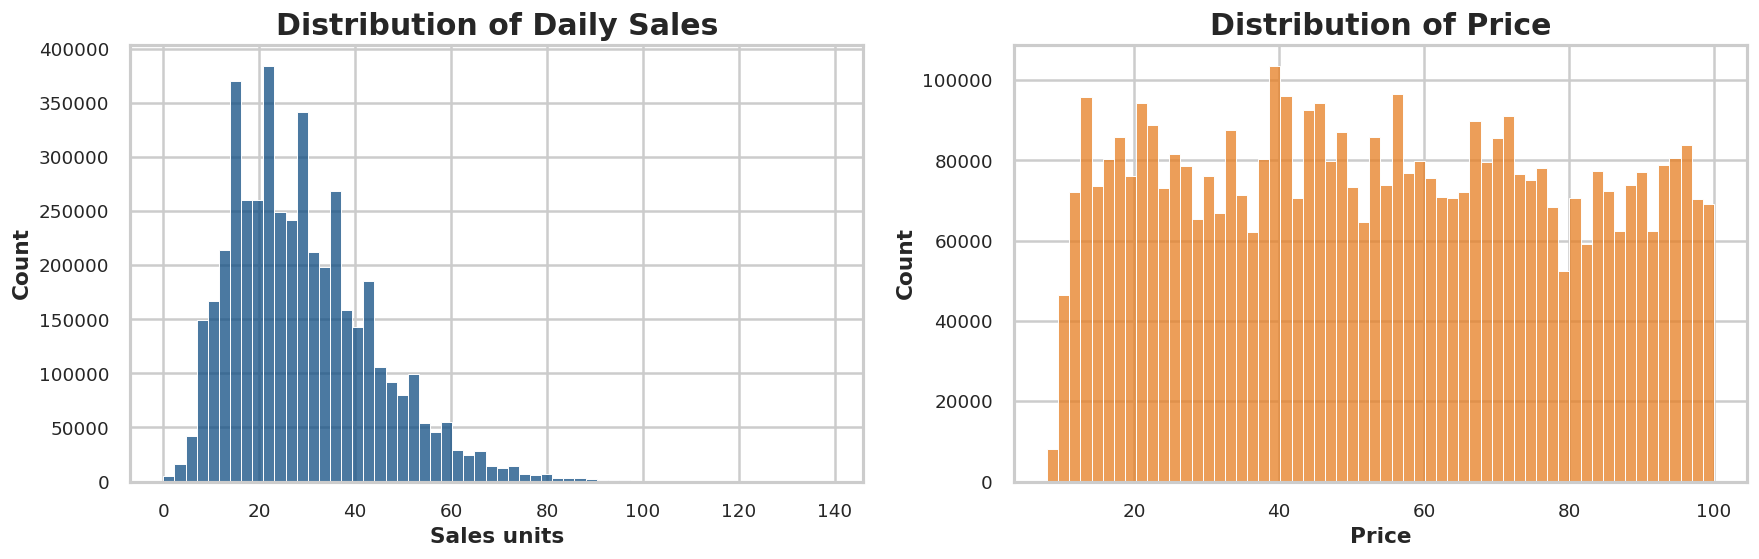

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(df["sales"], bins=60, color=palette_main[0], ax=axes[0])
axes[0].set_title("Distribution of Daily Sales")
axes[0].set_xlabel("Sales units")
axes[0].set_ylabel("Count")

sns.histplot(df["price"], bins=60, color=palette_main[1], ax=axes[1])
axes[1].set_title("Distribution of Price")
axes[1].set_xlabel("Price")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

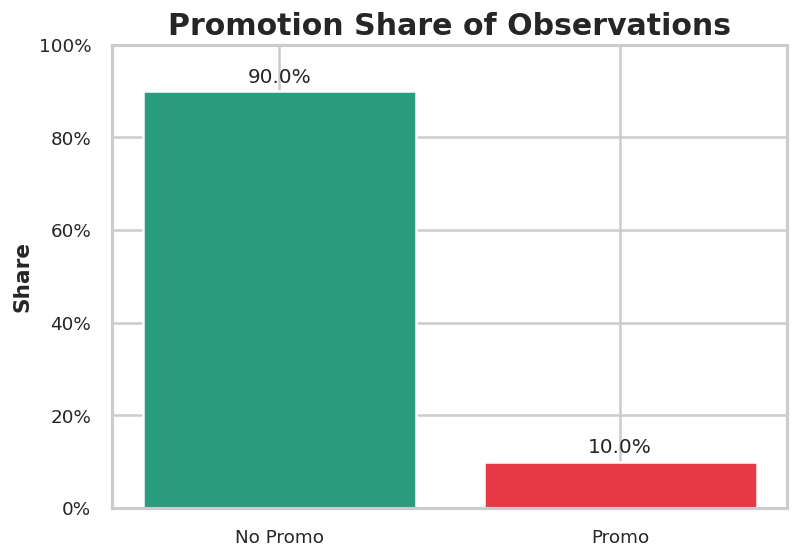

In [ ]:
promo_share = df["promo"].mean()
non_promo_share = 1 - promo_share

fig, ax = plt.subplots(figsize=(7, 5))
ax.bar(["No Promo", "Promo"], [non_promo_share, promo_share], color=[palette_main[2], palette_main[3]])
ax.set_title("Promotion Share of Observations")
ax.set_ylabel("Share")
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0%}"))
for i, v in enumerate([non_promo_share, promo_share]):
    ax.text(i, v + 0.01, f"{v:.1%}", ha="center", va="bottom", fontsize=12)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

Time-Series Patterns

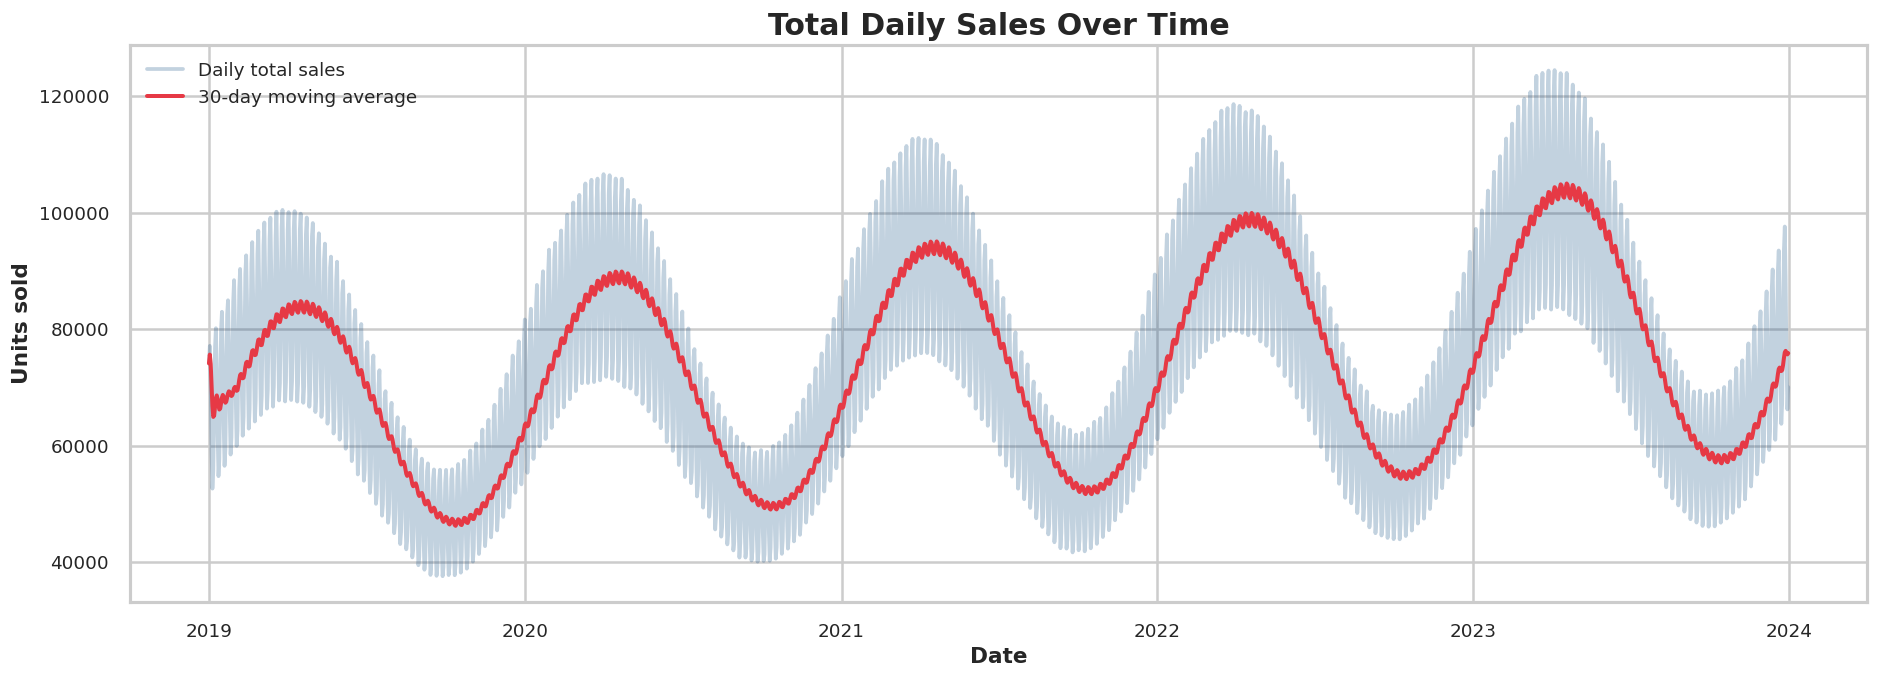

In [ ]:
daily = (
    df.groupby("date", as_index=False)
    .agg(
        total_sales=("sales", "sum"),
        avg_price=("price", "mean"),
        promo_rate=("promo", "mean"),
    )
    .sort_values("date")
)
daily["sales_30d_ma"] = daily["total_sales"].rolling(30, min_periods=1).mean()

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(daily["date"], daily["total_sales"], color=palette_main[0], alpha=0.25, label="Daily total sales")
ax.plot(daily["date"], daily["sales_30d_ma"], color=palette_main[3], linewidth=2.4, label="30-day moving average")
ax.set_title("Total Daily Sales Over Time")
ax.set_xlabel("Date")
ax.set_ylabel("Units sold")
ax.legend(loc="upper left")
plt.tight_layout()
plt.show()

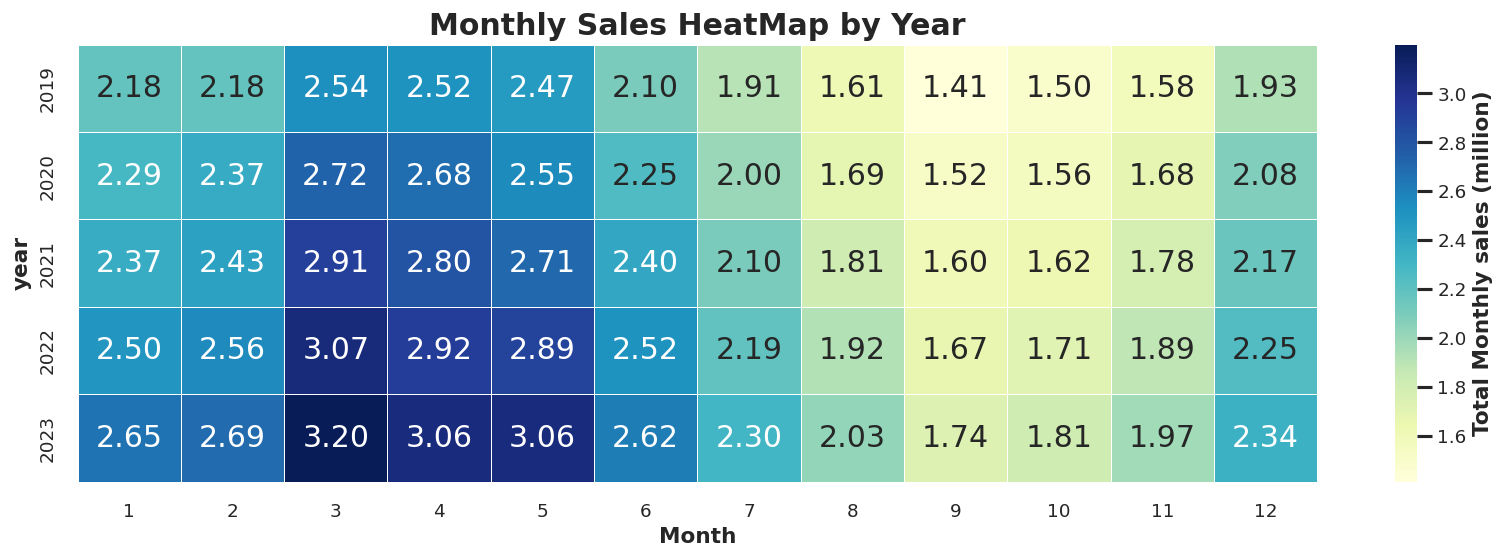

In [ ]:
monthly_sales = (
      daily.assign(year=daily["date"].dt.year, month = daily['date'].dt.month).pivot_table(index="year",columns="month", values= "total_sales", aggfunc='sum')
)
fig  , ax = plt.subplots(figsize=(14, 5))
sns.heatmap(
    monthly_sales / 1_000_000,
    cmap="YlGnBu",
    annot=True,
    fmt=".2f",
    linewidths=0.4,
    cbar_kws={"label": "Total Monthly sales (million)"},
    ax = ax,
)
ax.set_title("Monthly Sales HeatMap by Year")
ax.set_xlabel("Month")
plt.tight_layout()
plt.show()

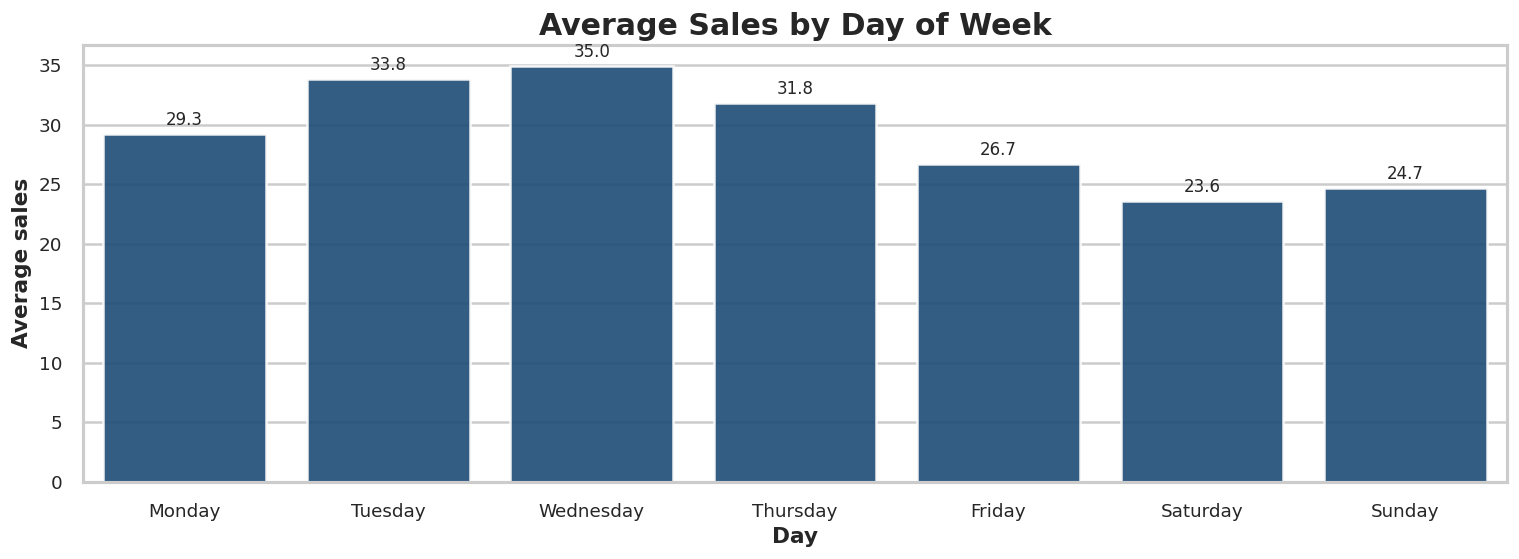

In [ ]:
weekday_sales = (
    df.groupby("day_name", observed=True, as_index=False)
    .agg(avg_sales=("sales", "mean"), avg_price=("price", "mean"), promo_rate=("promo", "mean"))
)

fig, ax1 = plt.subplots(figsize=(13, 5))

sns.barplot(
    data=weekday_sales,
    x="day_name",
    y="avg_sales",
    color=palette_main[0],
    alpha=0.9,
    ax=ax1,
)
ax1.set_title("Average Sales by Day of Week")
ax1.set_xlabel("Day")
ax1.set_ylabel("Average sales")

for p in ax1.patches:
    ax1.annotate(
        f"{p.get_height():.1f}",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=10,
        xytext=(0, 3),
        textcoords="offset points",
    )

plt.tight_layout()
plt.show()

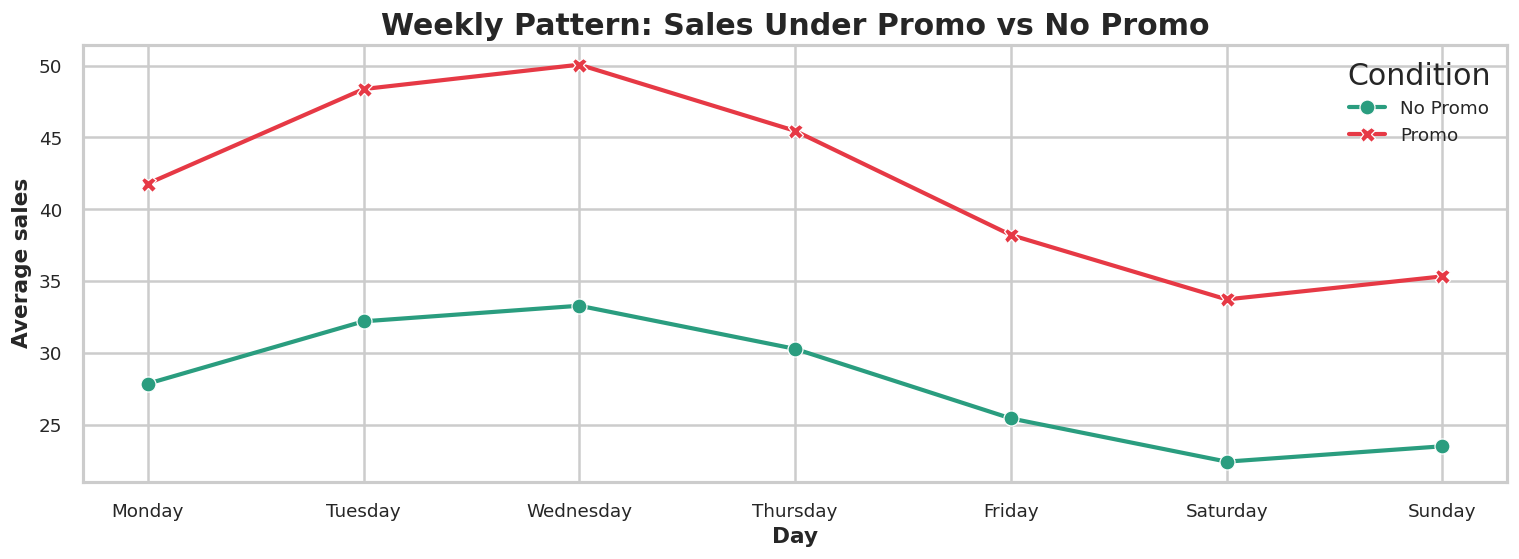

In [ ]:
weekday_promo = (
    df.groupby(["day_name", "promo"], observed=True, as_index=False)["sales"]
    .mean()
    .rename(columns={"sales": "avg_sales"})
)
weekday_promo["promo_label"] = weekday_promo["promo"].map({0: "No Promo", 1: "Promo"})

fig, ax = plt.subplots(figsize=(13, 5))
sns.lineplot(
    data=weekday_promo,
    x="day_name",
    y="avg_sales",
    hue="promo_label",
    style="promo_label",
    markers=True,
    dashes=False,
    linewidth=2.5,
    palette=[palette_main[2], palette_main[3]],
    ax=ax,
)
ax.set_title("Weekly Pattern: Sales Under Promo vs No Promo")
ax.set_xlabel("Day")
ax.set_ylabel("Average sales")
ax.legend(title="Condition")
plt.tight_layout()
plt.show()

Store and Item Performance

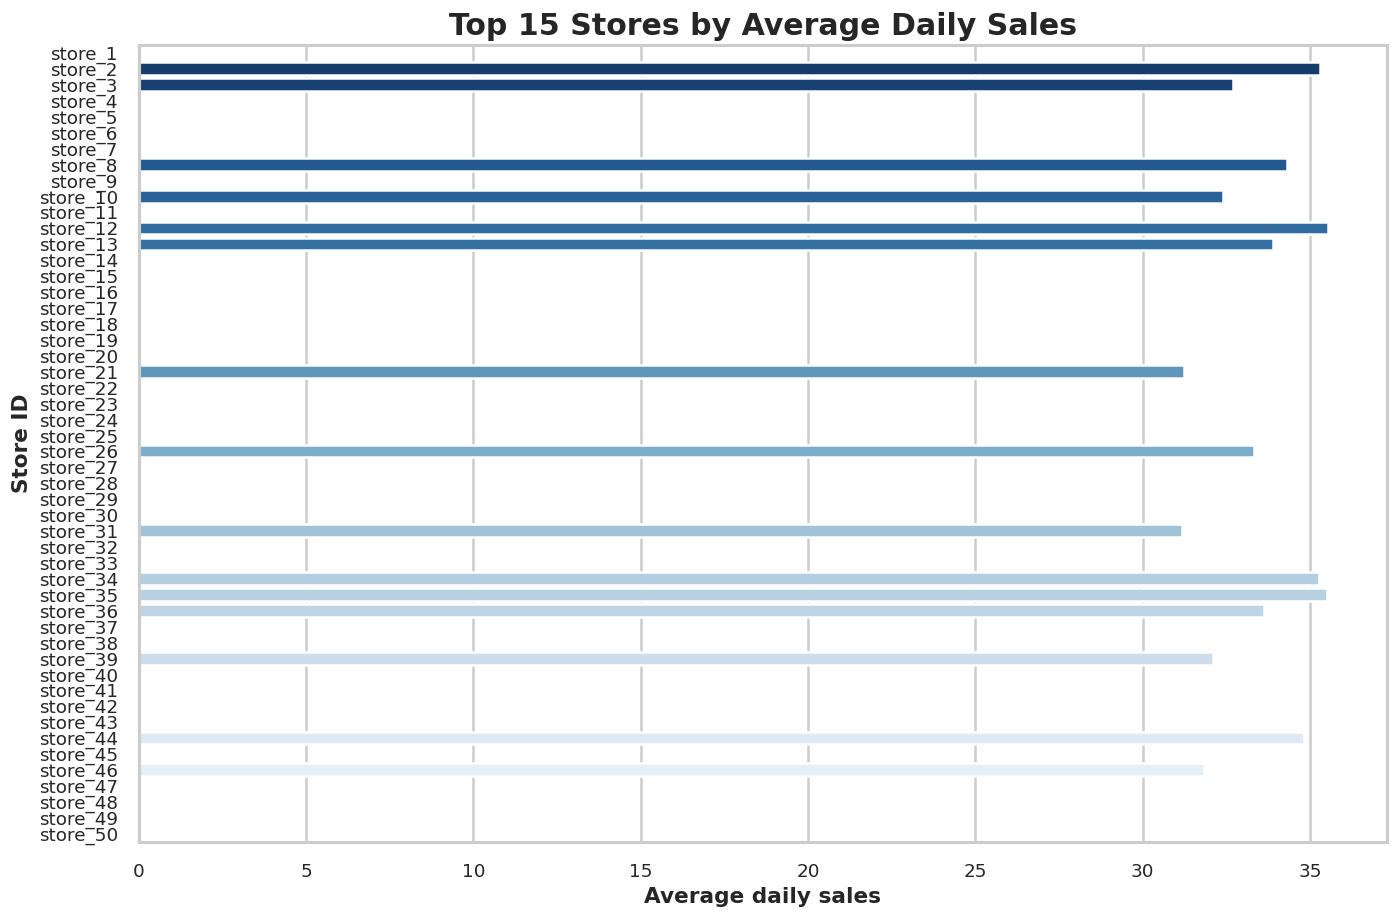

,store_id,avg_sales,total_sales,avg_price,promo_rate
11,store_12,35.525696,3243496,50.133965,0.099518
34,store_35,35.492815,3240494,55.970623,0.100745
1,store_2,35.281654,3221215,53.279972,0.099792
33,store_34,35.256386,3218908,47.270596,0.099365
43,store_44,34.826583,3179667,56.812168,0.100372


In [ ]:
store_perf = (
    df.groupby("store_id", as_index=False)
    .agg(
        avg_sales=("sales", "mean"),
        total_sales=("sales", "sum"),
        avg_price=("price", "mean"),
        promo_rate=("promo", "mean"),
    )
    .sort_values("avg_sales", ascending=False)
)

top_stores = store_perf.head(15)

fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(data=top_stores, y="store_id", x="avg_sales", palette="Blues_r", ax=ax)
ax.set_title("Top 15 Stores by Average Daily Sales")
ax.set_xlabel("Average daily sales")
ax.set_ylabel("Store ID")
plt.tight_layout()
plt.show()

store_perf.head()

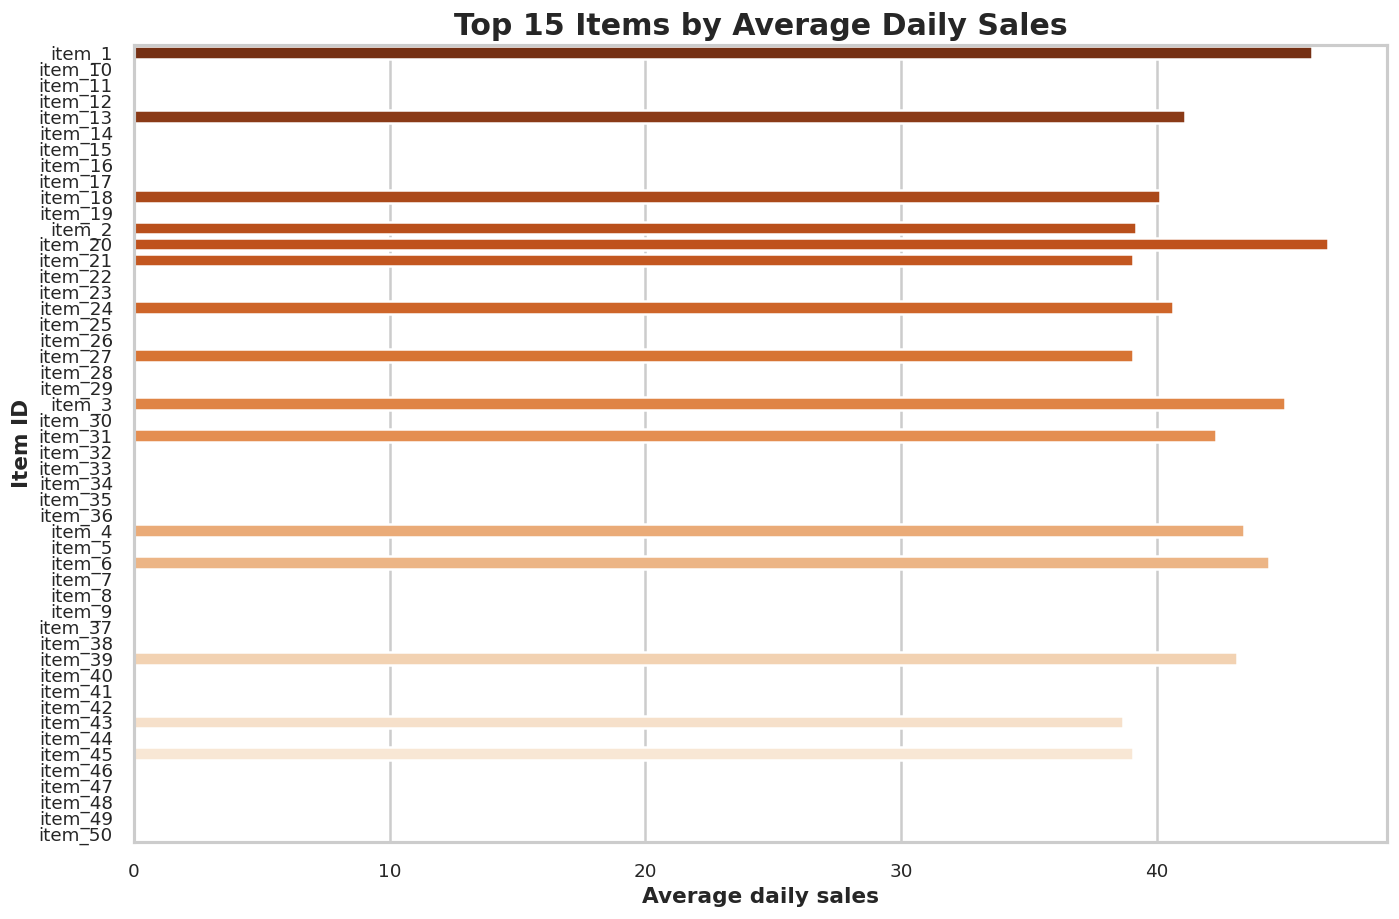

,item_id,avg_sales,total_sales,avg_price,promo_rate
12,item_20,46.675871,4261507,55.302048,0.100405
0,item_1,46.079573,4207065,56.015743,0.100690
22,item_3,45.000591,4108554,54.592159,0.100372
32,item_6,44.374732,4051413,53.397667,0.100329
30,item_4,43.423658,3964580,58.650455,0.100394


In [ ]:
item_perf = (
    df.groupby("item_id", as_index=False)
    .agg(
        avg_sales=("sales", "mean"),
        total_sales=("sales", "sum"),
        avg_price=("price", "mean"),
        promo_rate=("promo", "mean"),
    )
    .sort_values("avg_sales", ascending=False)
)

top_items = item_perf.head(15)

fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(data=top_items, y="item_id", x="avg_sales", palette="Oranges_r", ax=ax)
ax.set_title("Top 15 Items by Average Daily Sales")
ax.set_xlabel("Average daily sales")
ax.set_ylabel("Item ID")
plt.tight_layout()
plt.show()

item_perf.head()

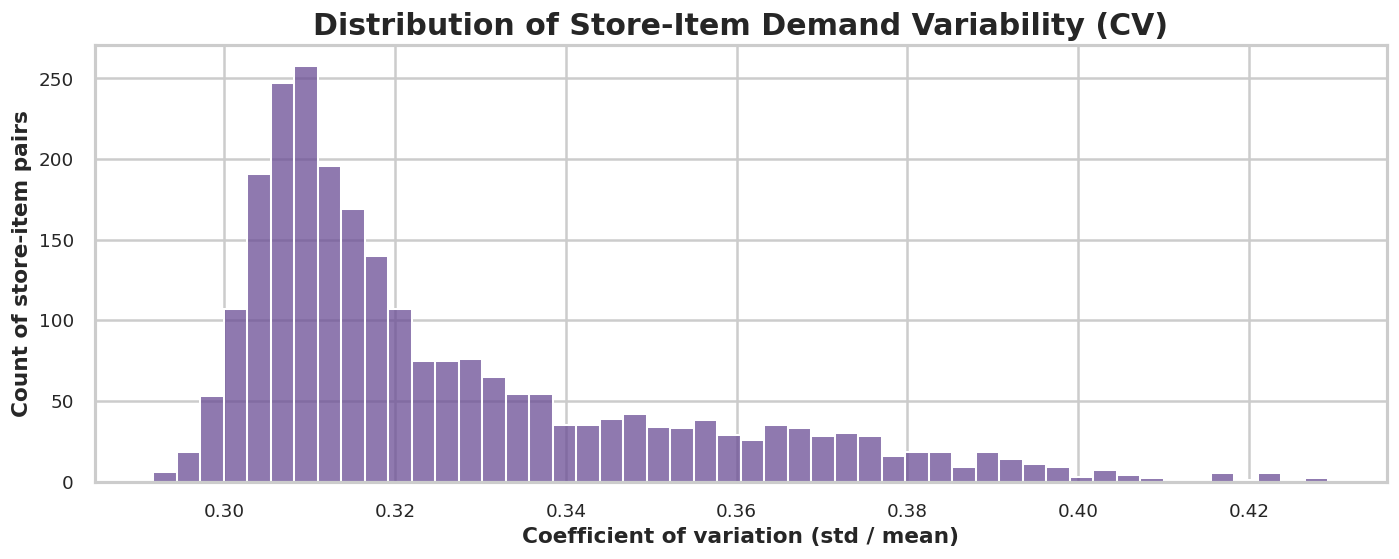

,store_id,item_id,mean_sales,std_sales,cv
2115,store_43,item_23,9.983023,4.285718,0.429301
1615,store_33,item_23,10.155531,4.355807,0.428910
215,store_5,item_23,10.477547,4.433470,0.423140
1865,store_38,item_23,10.208105,4.315688,0.422771
315,store_7,item_23,10.055860,4.242014,0.421845
1465,store_30,item_23,10.064622,4.242148,0.421491
515,store_11,item_23,9.778751,4.121086,0.421433
1065,store_22,item_23,10.479189,4.393501,0.419260
2015,store_41,item_23,10.405257,4.351672,0.418219
348,store_7,item_49,10.673604,4.448639,0.416789


In [ ]:
pair_variability = (
    df.groupby(["store_id", "item_id"], as_index=False)
    .agg(mean_sales=("sales", "mean"), std_sales=("sales", "std"))
)
pair_variability["cv"] = pair_variability["std_sales"] / pair_variability["mean_sales"].replace(0, np.nan)

fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(pair_variability["cv"].dropna(), bins=50, color=palette_main[4], ax=ax)
ax.set_title("Distribution of Store-Item Demand Variability (CV)")
ax.set_xlabel("Coefficient of variation (std / mean)")
ax.set_ylabel("Count of store-item pairs")
plt.tight_layout()
plt.show()

pair_variability.sort_values("cv", ascending=False).head(10)

 Promotions and Pricing Effects

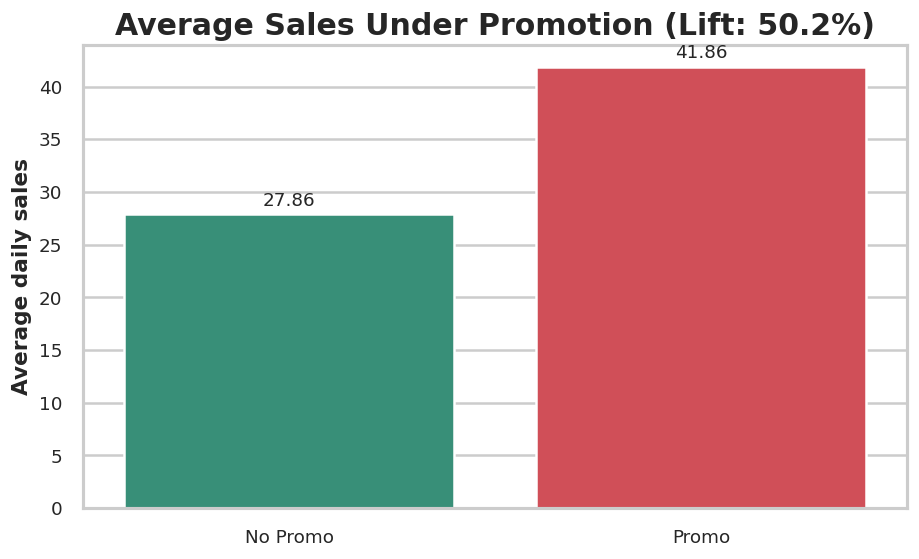

,promo,avg_sales,label
0,0.0,27.864828,No Promo
1,1.0,41.863337,Promo


In [ ]:
promo_impact = df.groupby("promo", as_index=False)["sales"].mean().rename(columns={"sales": "avg_sales"})
promo_impact["label"] = promo_impact["promo"].map({0: "No Promo", 1: "Promo"})

baseline = promo_impact.loc[promo_impact["promo"] == 0, "avg_sales"].iloc[0]
lift = (promo_impact.loc[promo_impact["promo"] == 1, "avg_sales"].iloc[0] - baseline) / baseline * 100

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(data=promo_impact, x="label", y="avg_sales", palette=[palette_main[2], palette_main[3]], ax=ax)
ax.set_title(f"Average Sales Under Promotion (Lift: {lift:.1f}%)")
ax.set_xlabel("")
ax.set_ylabel("Average daily sales")
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.2f}",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=11,
        xytext=(0, 3),
        textcoords="offset points",
    )
plt.tight_layout()
plt.show()

promo_impact


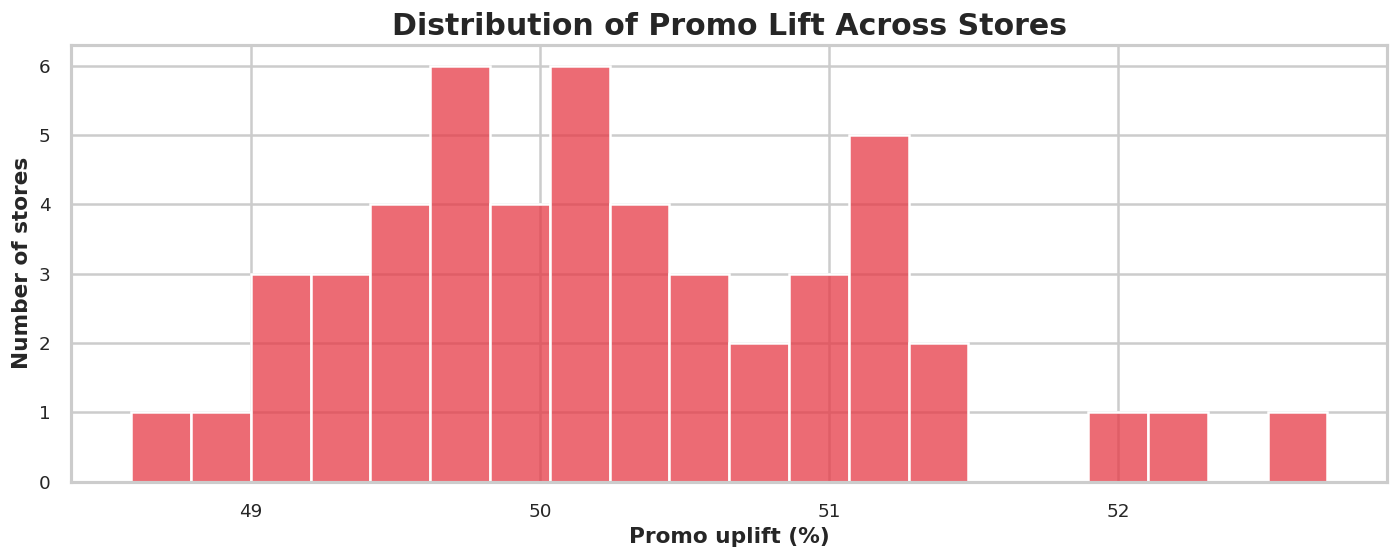

promo,no_promo,promo,uplift_pct
store_id,,,
store_17,26.192146,40.001213,52.722164
store_20,26.076910,39.700671,52.244539
store_4,29.568676,44.956350,52.040456
store_1,27.024588,40.922298,51.426167
store_27,25.036724,37.874973,51.277670
store_37,26.238259,39.683823,51.244113
store_18,28.755802,43.481586,51.209783
store_38,23.885159,36.112537,51.192368
store_16,24.859775,37.574309,51.145011


In [ ]:
store_uplift = (
    df.groupby(["store_id", "promo"], as_index=False)["sales"]
    .mean()
    .pivot(index="store_id", columns="promo", values="sales")
    .rename(columns={0: "no_promo", 1: "promo"})
)
store_uplift["uplift_pct"] = (store_uplift["promo"] - store_uplift["no_promo"]) / store_uplift["no_promo"] * 100

fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(store_uplift["uplift_pct"].dropna(), bins=20, color=palette_main[3], ax=ax)
ax.set_title("Distribution of Promo Lift Across Stores")
ax.set_xlabel("Promo uplift (%)")
ax.set_ylabel("Number of stores")
plt.tight_layout()
plt.show()

store_uplift.sort_values("uplift_pct", ascending=False).head(10)


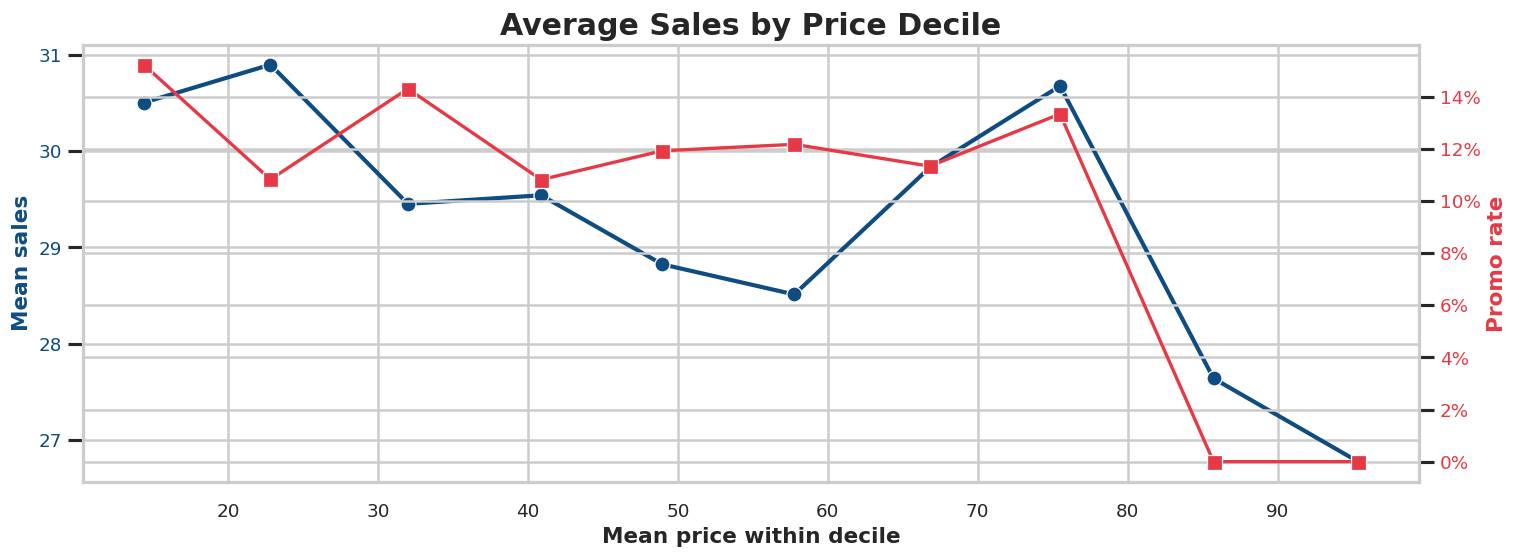

,price_decile,mean_price,mean_sales,promo_rate,observations
0,"(8.019, 18.7]",14.376198,30.500294,0.152301,457515
1,"(18.7, 27.01]",22.827503,30.894714,0.108273,456908
2,"(27.01, 36.87]",31.995205,29.450468,0.143056,456674
3,"(36.87, 44.78]",40.878571,29.539789,0.108175,457129
4,"(44.78, 53.52]",48.959198,28.823958,0.119254,455187
5,"(53.52, 62.12]",57.764915,28.510968,0.121732,458821
6,"(62.12, 71.06]",66.806206,29.828379,0.113362,453778
7,"(71.06, 80.71]",75.492111,30.673706,0.133401,457164
8,"(80.71, 90.61]",85.727730,27.640114,0.000000,456759
9,"(90.61, 99.99]",95.370621,26.776535,0.000000,455065


In [ ]:
price_bins = df[["price", "sales", "promo"]].copy()
price_bins["price_decile"] = pd.qcut(price_bins["price"], q=10, duplicates="drop")

price_decile_summary = (
    price_bins.groupby("price_decile", observed=True)
    .agg(
        mean_price=("price", "mean"),
        mean_sales=("sales", "mean"),
        promo_rate=("promo", "mean"),
        observations=("sales", "size"),
    )
    .reset_index()
)

fig, ax1 = plt.subplots(figsize=(13, 5))
ax2 = ax1.twinx()

sns.lineplot(
    data=price_decile_summary,
    x="mean_price",
    y="mean_sales",
    marker="o",
    linewidth=2.5,
    color=palette_main[0],
    ax=ax1,
)
ax1.set_title("Average Sales by Price Decile")
ax1.set_xlabel("Mean price within decile")
ax1.set_ylabel("Mean sales", color=palette_main[0])
ax1.tick_params(axis="y", labelcolor=palette_main[0])

sns.lineplot(
    data=price_decile_summary,
    x="mean_price",
    y="promo_rate",
    marker="s",
    linewidth=2,
    color=palette_main[3],
    ax=ax2,
)
ax2.set_ylabel("Promo rate", color=palette_main[3])
ax2.tick_params(axis="y", labelcolor=palette_main[3])
ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0%}"))

plt.tight_layout()
plt.show()

price_decile_summary


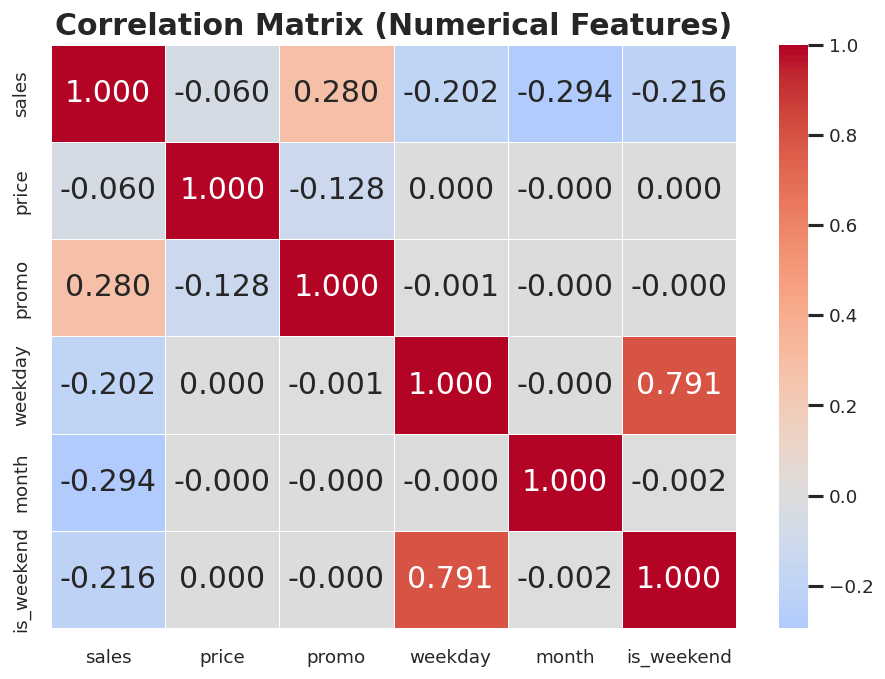

,sales,price,promo,weekday,month,is_weekend
sales,1.000000,-0.059668,0.279783,-0.202356,-0.293750,-0.216436
price,-0.059668,1.000000,-0.127944,0.000072,-0.000026,0.000053
promo,0.279783,-0.127944,1.000000,-0.000733,-0.000072,-0.000430
weekday,-0.202356,0.000072,-0.000733,1.000000,-0.000363,0.790624
month,-0.293750,-0.000026,-0.000072,-0.000363,1.000000,-0.001860
is_weekend,-0.216436,0.000053,-0.000430,0.790624,-0.001860,1.000000


In [ ]:
corr = df[["sales", "price", "promo", "weekday", "month", "is_weekend"]].corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".3f", cmap="coolwarm", center=0, linewidths=0.5, ax=ax)
ax.set_title("Correlation Matrix (Numerical Features)")
plt.tight_layout()
plt.show()

corr

Year-over-Year Summary

In [ ]:
yearly = (
    df.groupby("year", as_index=False)
    .agg(
        total_sales=("sales", "sum"),
        avg_sales=("sales", "mean"),
        avg_price=("price", "mean"),
        promo_rate=("promo", "mean"),
    )
)

yearly


,year,total_sales,avg_sales,avg_price,promo_rate
0,2019,23920749,26.214519,53.995625,0.099986
1,2020,25396425,27.755656,53.995461,0.099796
2,2021,26706877,29.267810,53.988731,0.100485
3,2022,28083973,30.776957,53.992393,0.099950
4,2023,29485150,32.312493,53.993942,0.099778


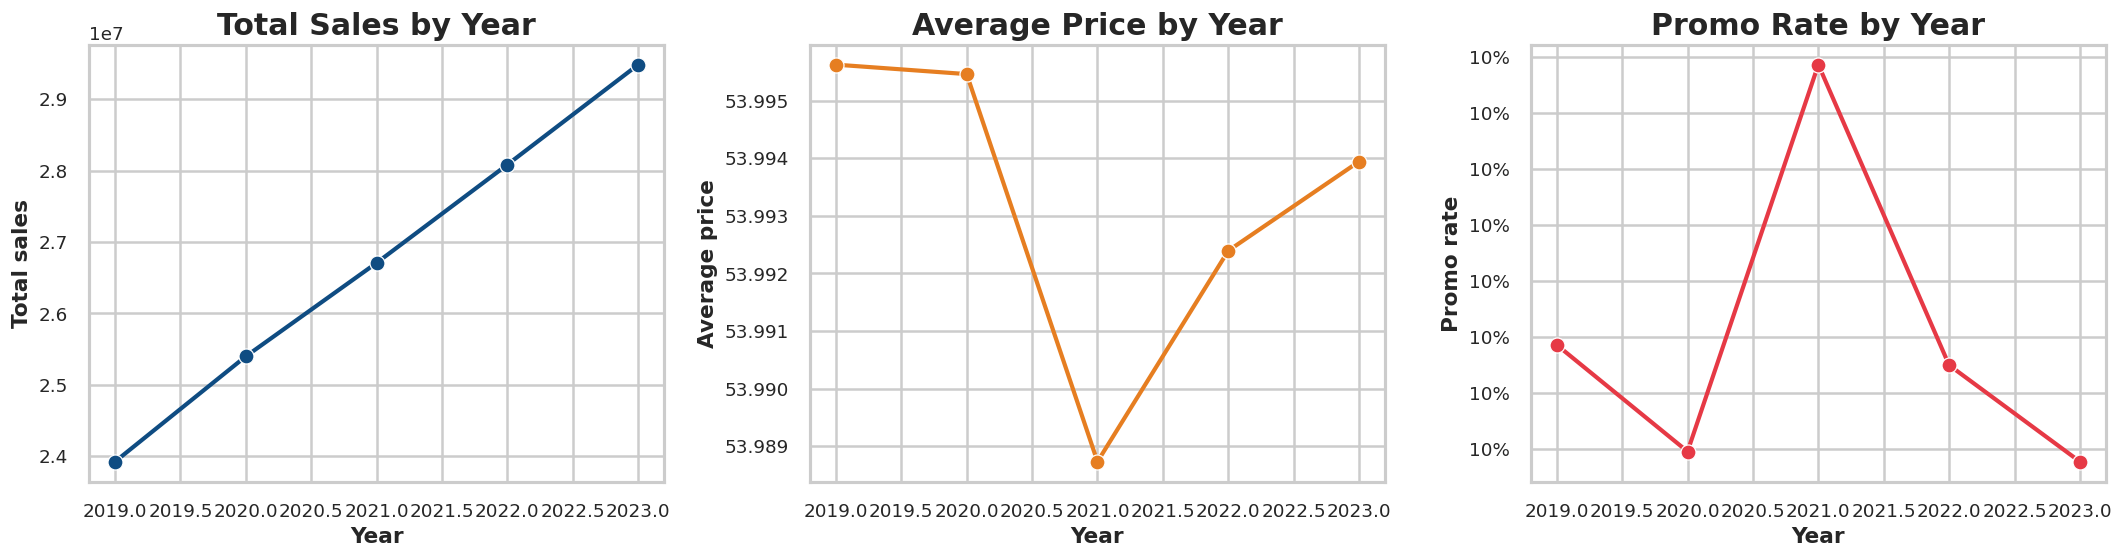

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.lineplot(data=yearly, x="year", y="total_sales", marker="o", linewidth=2.5, color=palette_main[0], ax=axes[0])
axes[0].set_title("Total Sales by Year")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Total sales")

sns.lineplot(data=yearly, x="year", y="avg_price", marker="o", linewidth=2.5, color=palette_main[1], ax=axes[1])
axes[1].set_title("Average Price by Year")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Average price")

sns.lineplot(data=yearly, x="year", y="promo_rate", marker="o", linewidth=2.5, color=palette_main[3], ax=axes[2])
axes[2].set_title("Promo Rate by Year")
axes[2].set_xlabel("Year")
axes[2].set_ylabel("Promo rate")
axes[2].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0%}"))

plt.tight_layout()
plt.show()



Auto-Generated Insight Snapshot

In [ ]:
insights = {
    "date_range": f"{start_date.date()} to {end_date.date()}",
    "rows": int(len(df)),
    "stores": int(num_stores),
    "items": int(num_items),
    "promo_share_pct": round(float(df["promo"].mean() * 100), 2),
    "avg_daily_sales_per_record": round(float(df["sales"].mean()), 2),
    "avg_price": round(float(df["price"].mean()), 2),
    "promo_sales_lift_pct": round(float(lift), 2),
    "best_store_avg_sales": round(float(store_perf.iloc[0]["avg_sales"]), 2),
    "best_item_avg_sales": round(float(item_perf.iloc[0]["avg_sales"]), 2),
    "highest_store_promo_lift_pct": round(float(store_uplift["uplift_pct"].max()), 2),
}

pd.Series(insights, name="value").to_frame()


,value
date_range,2019-01-01 to 2023-12-31
rows,4565000
stores,50
items,50
promo_share_pct,10.0
avg_daily_sales_per_record,29.26
avg_price,53.99
promo_sales_lift_pct,50.24
best_store_avg_sales,35.53
best_item_avg_sales,46.68
